# 🧠 Eliminación de Componentes ICA de Artefactos Musculares en EEG/MEG

## Introducción
El artefacto muscular es una fuente común de ruido en las grabaciones de electroencefalografía (EEG). Mientras que los movimientos bruscos a menudo requieren que se rechace la época [1], el artefacto muscular producido durante el mantenimiento postural es más ubicuo [2] y es el que se debe eliminar mediante ICA, ya que de otro modo no quedarían épocas [3].  
Es importante notar que los artefactos musculares de este tipo son mucho más pronunciados en EEG que en MEG [4].

## Objetivos
El principal objetivo es **identificar y eliminar los componentes ICA** que capturan el artefacto muscular [5].  
Esto se hace para aislar y remover el ruido muscular persistente (principalmente de origen postural) y, consecuentemente, mejorar la calidad de la señal EEG/MEG para el análisis posterior.

## Pasos Generales

### 1. Preparación de los Datos
- **Cargar y Recortar:** Cargar los datos *raw* y, opcionalmente, recortarlos para acelerar el procesamiento [6].  
- **Selección de Canales:** Seleccionar solo los canales EEG ya que el artefacto muscular es básicamente no detectado por MEG [7].  
- **Filtrado de Paso Alto:** Cargar los datos y aplicar un filtro de paso alto (por ejemplo, `l_freq=1.0`) ya que ICA funciona mejor con un filtro de paso alto aplicado [8].

### 2. Ejecución de ICA
- **Inicializar y ajustar el modelo ICA** (`mne.preprocessing.ICA`), especificando el número de componentes y el método (por ejemplo, `"picard"`) [9].

### 3. Identificación de Componentes Musculares
#### Manual
- **Inspeccionar visualmente** las fuentes ICA (`ica.plot_sources(raw)`) [10] y sus propiedades (`ica.plot_properties`) para seleccionar los índices de artefactos musculares (`muscle_idx`) [11].  
- **Criterios clave:**  
  - Pendiente positiva del espectro de potencia log-log entre 7 y 75 Hz (mínimo en ≈10 Hz, máximo en ≈25 Hz es un patrón muy típico) [12].  
  - Foco periférico o monopolar en el topomapa (por ejemplo, cerca del músculo temporal) [13].  
  - Curso temporal que se asemeja a una señal EMG [14].

#### Automática
- Utilizar el algoritmo `ica.find_bads_muscle(raw)` para obtener una lista automática de índices musculares (`muscle_idx_auto`) [15].

### 4. Aplicación de la Limpieza
- Aplicar el modelo ICA a los datos *raw*, **excluyendo los componentes identificados** (por ejemplo, `blink_idx`, `heartbeat_idx` y `muscle_idx`) [16].

### 5. Verificación
- Visualizar la señal antes (rojo) y después (negro) de la limpieza (`ica.plot_overlay`) para asegurar que el artefacto ha sido efectivamente removido [17].

Forma cruda: (180227, 8) (muestras x canales) | fs: 250.0 Hz
Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transiti

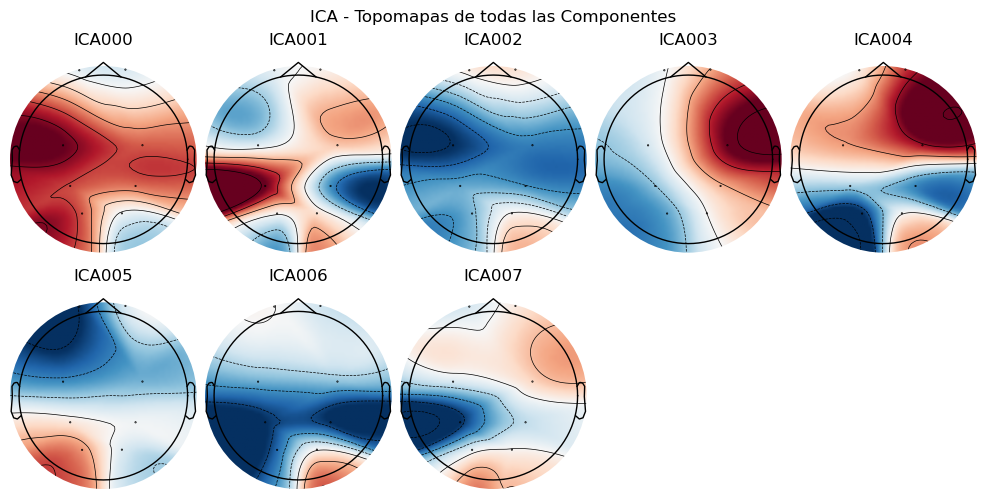

Creating RawArray with float64 data, n_channels=8, n_times=7501
    Range : 0 ... 7500 =      0.000 ...    30.000 secs
Ready.


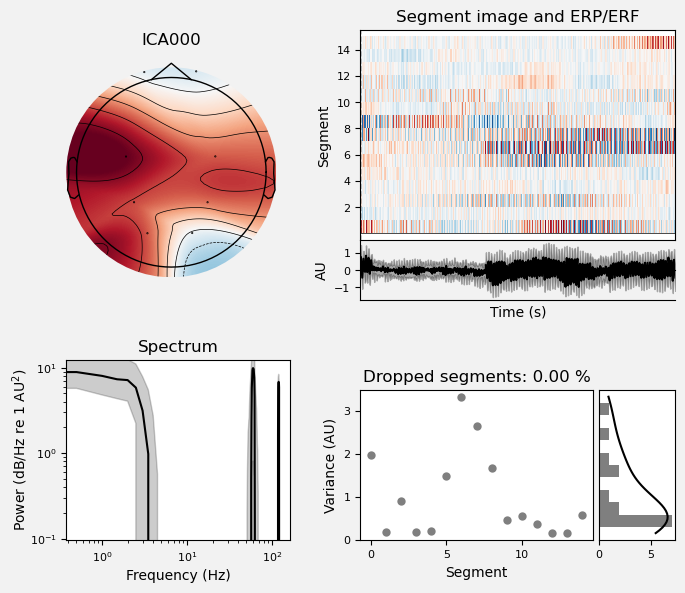

/opt/anaconda3/envs/mne/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


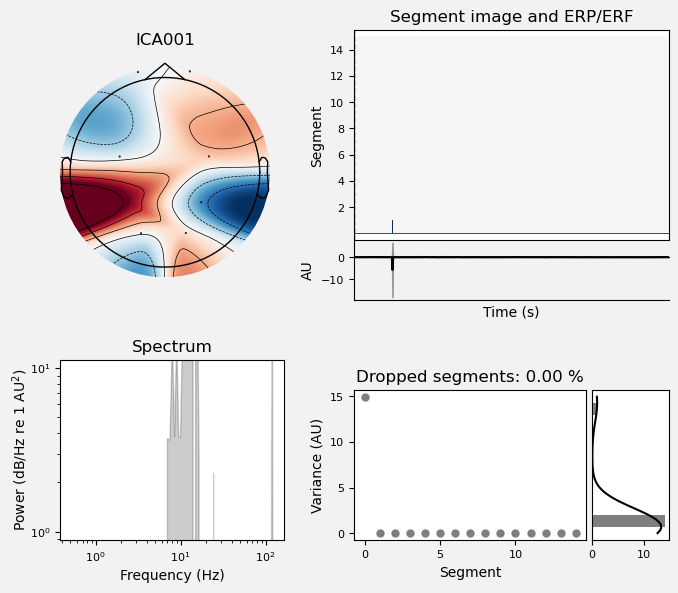

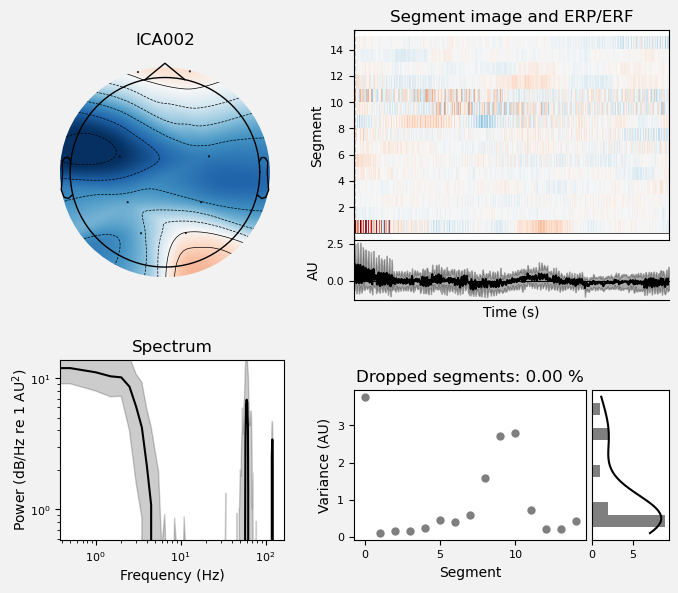

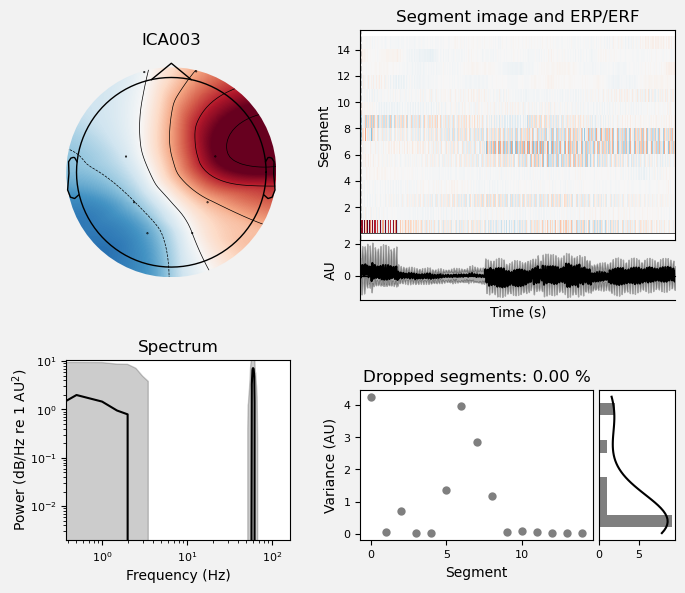

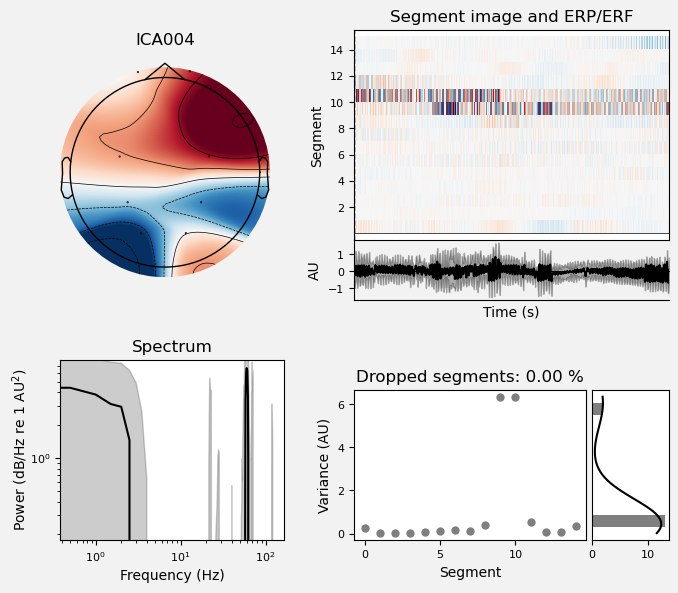

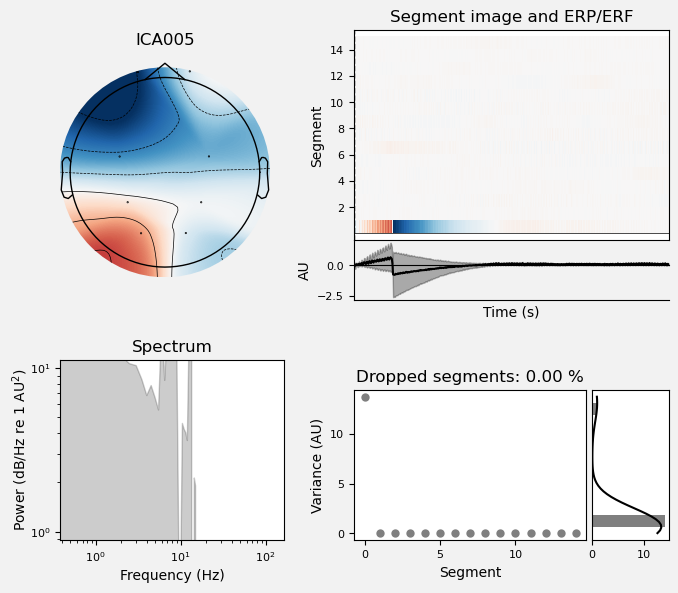

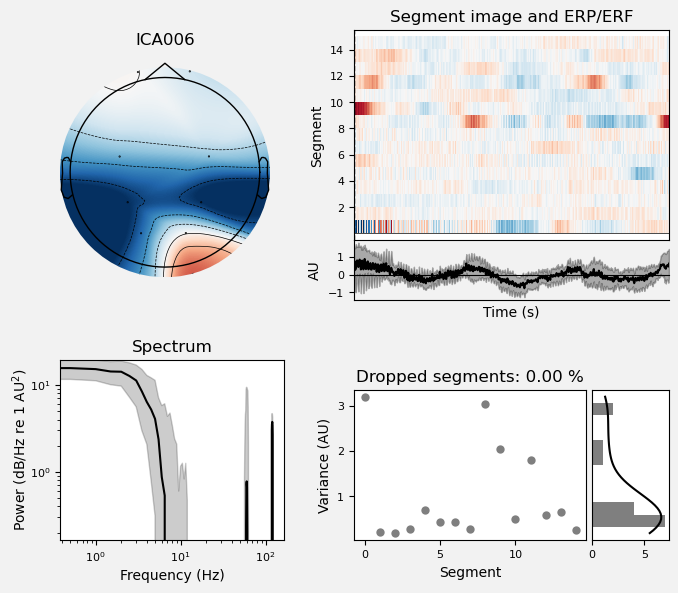

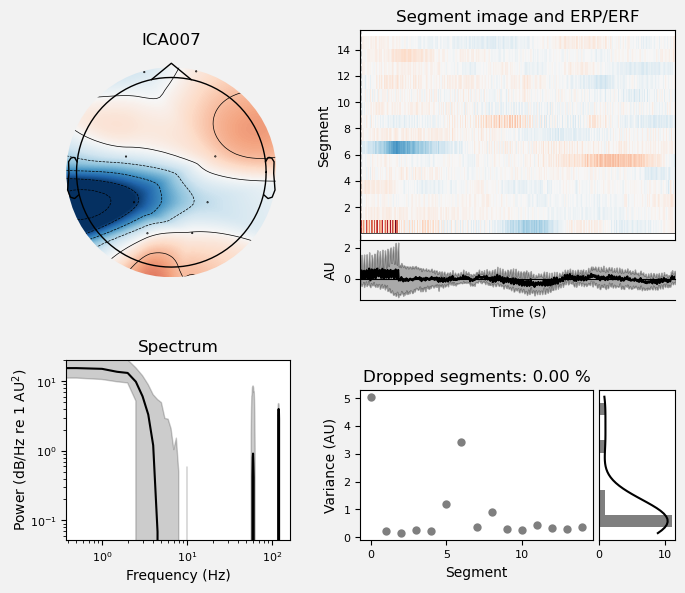

Effective window size : 8.192 (s)
Candidatos EMG (auto): [0, 1, 2, 3, 4, 7]


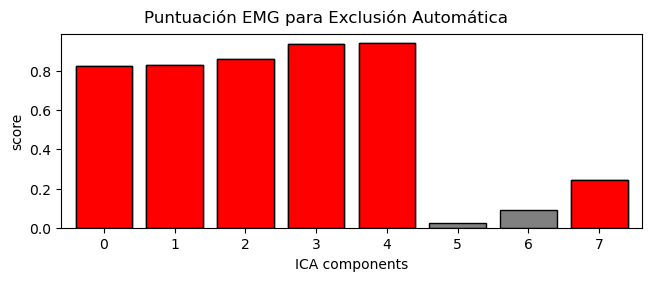

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


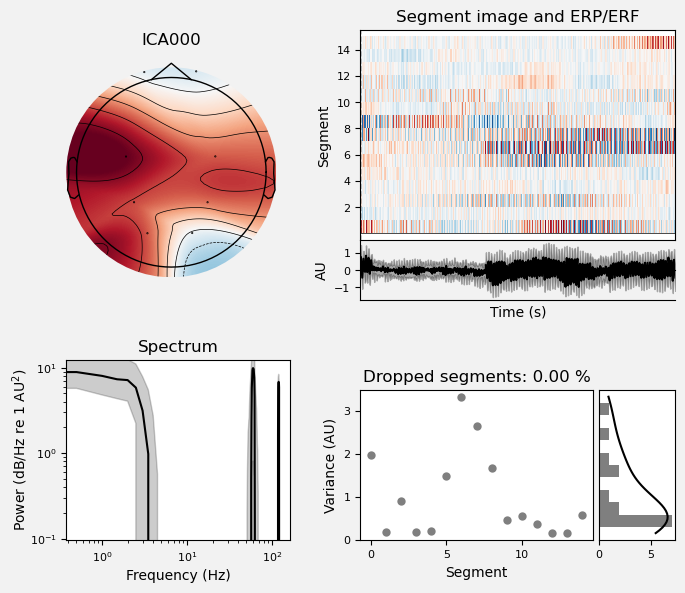

/opt/anaconda3/envs/mne/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


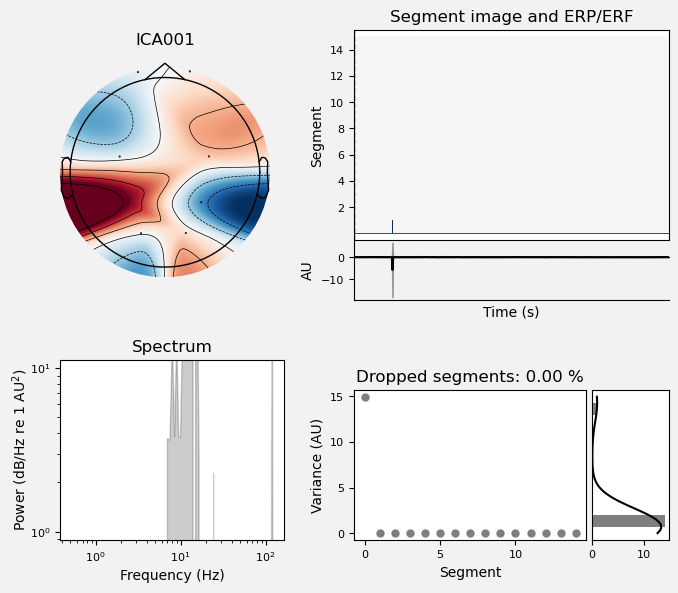

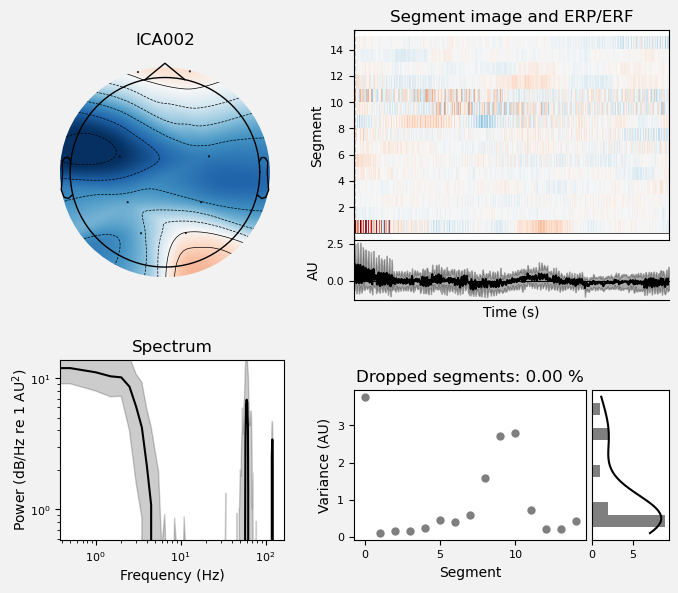

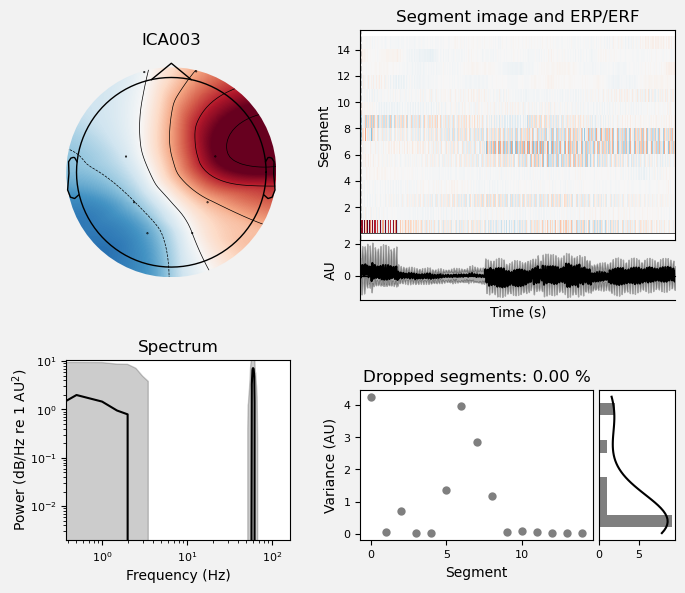

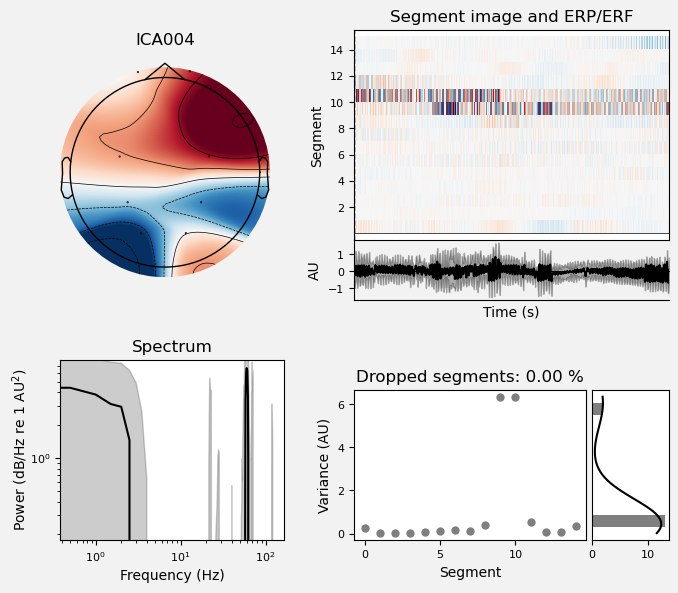

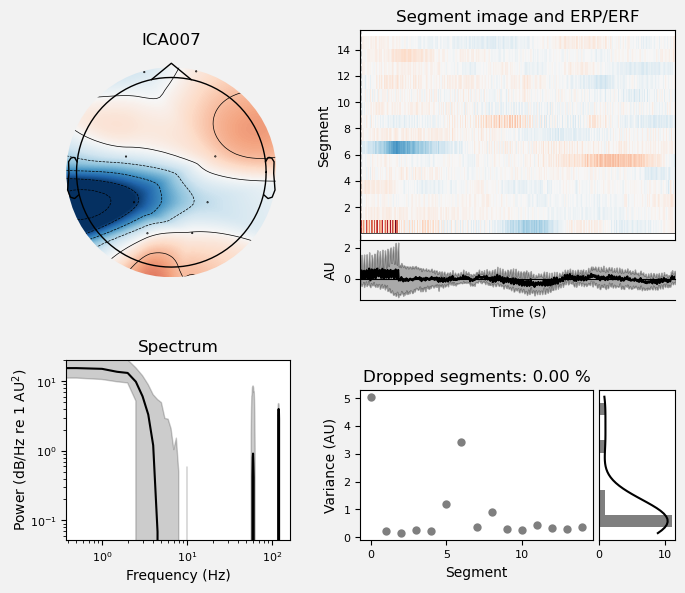

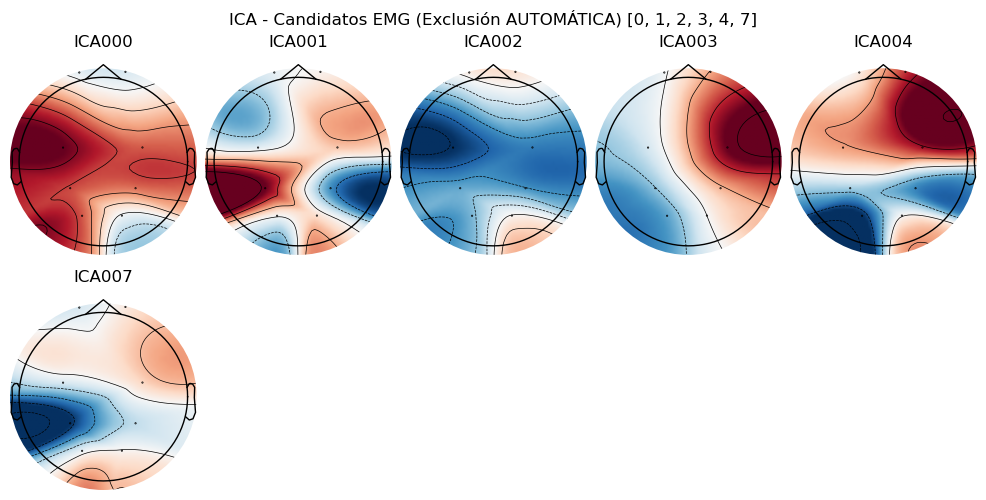


--- Aplicando ICA, excluyendo componentes: [0, 1, 7] ---


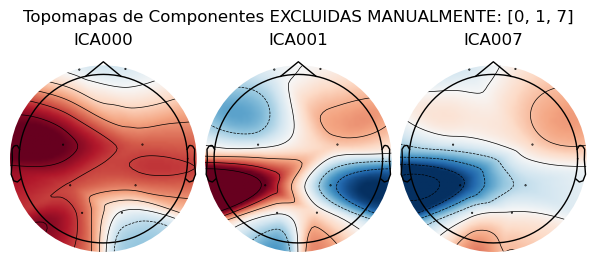

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


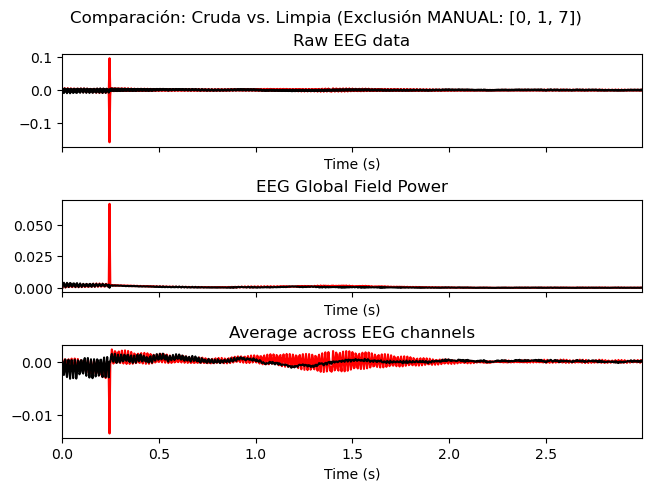

In [2]:
# === OpenBCI → MNE: ICA + gráficas, con montage garantizado ===
import os, re
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA

# -------- CONFIG --------
# Importante: el path a tu archivo debe ser accesible
fname = r"/Users/lucianatarazona/Downloads/OpenBCI-RAW-2025-09-17_12-45-51 (1).txt"
n_eeg = 8
sfreq_default = 250.0
hp_cut = 1.0
notch = 60.0 # Filtro de ruido eléctrico para 60 Hz (América)
ica_ncomp = None

# Método ICA con fallback automático
try:
    import picard  # noqa
    ica_method = "picard"
except Exception:
    ica_method = "fastica"
    
# -------- 1) Lectura robusta --------
if not os.path.exists(fname):
    # Si te sale este error, revisa el path en la línea 9
    raise FileNotFoundError(fname) 

df = pd.read_csv(
    fname,
    comment="%",
    sep=r"[\t,;]+",
    engine="python",
    header=None,
    on_bad_lines="skip",
    skip_blank_lines=True,
)

df = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all").dropna(axis=0, how="all")

# Columnas EEG por posición (típico: col0=sample, 1..8=EEG)
if df.shape[1] >= n_eeg + 1:
    eeg_block = df.iloc[:, 1:1+n_eeg].to_numpy()
else:
    eeg_block = df.iloc[:, :n_eeg].to_numpy()

# -------- 2) Estimar fs si hay timestamp Unix --------
sfreq = sfreq_default
for c in df.columns[::-1][:5]:
    v = pd.to_numeric(df[c], errors="coerce").to_numpy()
    # Detecta timestamp Unix (valor grande > 10^9)
    if np.nanmax(v) > 1e9: 
        dt = np.diff(v)
        dt = dt[(dt > 0) & np.isfinite(dt)]
        if dt.size > 100:
            est = 1.0 / np.median(dt)
            if 100 <= est <= 1000:
                sfreq = float(np.round(est, 1))
        break

print(f"Forma cruda: {eeg_block.shape} (muestras x canales) | fs: {sfreq} Hz")

# -------- 3) A MNE (canales x tiempo, en Voltios) --------
data = eeg_block.T
# Si los valores son grandes, asume µV y convierte a V
if np.nanmedian(np.abs(data)) > 1e3: 
    data = data / 1e6

# (CLAVE) Nombres estándar 10–20 para que el montage funcione
std_1020_names = ['Fp1','Fp2','C3','C4','P3','P4','O1','O2'][:data.shape[0]]

info = mne.create_info(ch_names=std_1020_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)

# Asignar montage: ahora sí encuentra coordenadas 3D para topomaps
mont = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(mont, match_case=False, on_missing='ignore')

# (opcional) recorta a 30 s para que cargue rápido
if raw.times[-1] > 30:
    raw.crop(tmin=0, tmax=30)

# -------- 4) Preprocesado --------
raw.load_data()
# Filtro pasa-alto (HPF) para eliminar deriva de línea base
raw.filter(l_freq=hp_cut, h_freq=None, fir_design='firwin') 
# Filtro Notch para eliminar el ruido de 60 Hz
raw.notch_filter(freqs=[notch], fir_design='firwin') 
raw.pick(picks="eeg", exclude="bads")

# -------- 5) ICA --------
if ica_ncomp is None:
    ica_ncomp = min(20, raw.info['nchan'])
ica = ICA(n_components=ica_ncomp, method=ica_method, max_iter='auto', random_state=97)
ica.fit(raw)
print(f"ICA listo: {ica.n_components_} componentes")

# -------- 6) Gráficas --------
# A) Topomapas
ica.plot_components(picks=range(ica.n_components_), inst=raw, title='ICA - Topomapas de todas las Componentes')

# B) Fuentes temporales
ica.plot_sources(raw, title='ICA - Fuentes Temporales (Time Courses)')

# C) Propiedades
ica.plot_properties(raw, picks=range(ica.n_components_), log_scale=True, verbose=False)

# -------- 7) Detección automática de músculo --------
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
print("Candidatos EMG (auto):", muscle_idx_auto)
ica.plot_scores(scores, exclude=muscle_idx_auto, title='Puntuación EMG para Exclusión Automática')
if muscle_idx_auto:
    # plot_properties no acepta título, pero la salida es clara
    ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True) 
    # TÍTULO EXPLÍCITO DE DETECCIÓN AUTOMÁTICA
    ica.plot_components(picks=muscle_idx_auto, inst=raw, title=f'ICA - Candidatos EMG (Exclusión AUTOMÁTICA) {muscle_idx_auto}')

# -------- 8) Aplicar exclusión MANUAL y comparar --------
# *** LISTA DE COMPONENTES ICA A EXCLUIR MANUALMENTE ***
# AJUSTA ESTOS NÚMEROS ([0, 1, 7]) después de REVISAR TUS GRÁFICAS ICA
exclude = [0, 1, 7] # Ejemplos: 0=Ocular, 1=Músculo, 7=Ruido
# *****************************************************

raw_clean = raw.copy()
if exclude:
    print(f"\n--- Aplicando ICA, excluyendo componentes: {exclude} ---")
    
    # NUEVA GRÁFICA: Topomapas de las Componentes Excluidas MANUALMENTE
    ica.plot_components(picks=exclude, inst=raw, title=f'Topomapas de Componentes EXCLUIDAS MANUALMENTE: {exclude}')
    
    ica.apply(raw_clean, exclude=exclude)
    # TÍTULO EXPLÍCITO PARA COMPARACIÓN MANUAL
    ica.plot_overlay(raw, exclude=exclude, title=f'Comparación: Cruda vs. Limpia (Exclusión MANUAL: {exclude})')
    # TÍTULO EXPLÍCITO PARA SEÑAL LIMPIA
    raw_clean.plot(title=f"Señal Limpia (Componentes ICA excluidas manualmente: {exclude})")